# Deep Learning for Predictive Maintenance: LSTM model

This notebook attempts to use a deep learning model, Long Short Time Memory ([LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)) in particular, to predict component failures as described in the [Predictive Maintenance Modelling Guide](https://gallery.cortanaintelligence.com/Notebook/Predictive-Maintenance-Modelling-Guide-R-Notebook-1). Among the deep learning methods, LSTM models are appealing to the Predictive Maintenance domain due to the fact that they are very good at learning from sequences which lends itself to their applications using time series data. Predictive Mainrenance operates heavily on time series data so there may be merit in applying LSTMs in this domain. However, since predictive maintenance is not a typical domain for deep learning applications, the idea is a fairly new concept that needs investigation.

The traditional predictive maintenance machine learning models are based on *feature engineering* which is manual construction of right features using domain expertise and similar methods. This usually makes these models hard to reuse since feature engineering is specific to the problem scenerio and the available data which varies from one business to the other. Perhaps the most attractive part of applying deep learning in the predictive maintenance domain is the fact that these networks can automatically extract the right features from the data, eleminating the need for manual feature engineering. 

In the rest of this notebook, we make a first attempt to fit a two-layer LSTM model, using a subset of the data (telemetry data) provided in the [Predictive Maintenance Modelling Guide](https://gallery.cortanaintelligence.com/Notebook/Predictive-Maintenance-Modelling-Guide-R-Notebook-1). The notebook uses [keras](https://keras.io/) deep learning library running on CPU. Here is a list of possible extensions and contributions to this work.
* Using the full set of raw data from the modelling guide which include not just telemetry but data such as error messeges and maintenance records.
* time based splitting for train and test sets.
* Using data from all 100 machines which will mostly require running on GPU.
* Finding the right deep learning architecture and optimal hyperparameters (number of layers, etc..)


In [1]:
!pip install keras
!pip install azure-storage

  Running setup.py bdist_wheel for keras: started
  Running setup.py bdist_wheel for keras: finished with status 'done'
  Stored in directory: C:\Windows\ServiceProfiles\LocalService\AppData\Local\pip\Cache\wheels\48\82\42\f06a8c03a8f95ada523a81ba723e89f059693e6ad868d09727
  Running setup.py bdist_wheel for theano: started
  Running setup.py bdist_wheel for theano: finished with status 'done'
  Stored in directory: C:\Windows\ServiceProfiles\LocalService\AppData\Local\pip\Cache\wheels\d5\5b\93\433299b86e3e9b25f0f600e4e4ebf18e38eb7534ea518eba13
Successfully built keras theano


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from azure.storage.blob import BlockBlobService
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

Using TensorFlow backend.


In [3]:
azure_storage_account_name = "deeplearningcntkfb"
azure_storage_account_key = "ZeK8+b+SsNQFq5ynNu06cA31rCZYBCaBD9/UYh+zSAn2pRAY6KG3c+TWjlthE19h4JiZd0QT5g8V9KvG+G76lA=="

if azure_storage_account_name is None or azure_storage_account_key is None:
    raise Exception("You must provide a name and key for an Azure Storage account")

In [9]:
blob_service = BlockBlobService(azure_storage_account_name, azure_storage_account_key)
containercontents = blob_service.list_blobs('deeplearning')
blob_service.get_blob_to_path('deeplearning','labeledPdM.csv','labeledPdM.csv')

We use the  telemetry data averaged over last 3 hours and the corresponding labels already generated from failure data  as in the modelling guide since those steps remain the same. For future extensions, when other data sources are integrated, the raw data needs to be used for those data sources.

In [125]:
df = pd.read_csv('labeledPdM.csv')
sub_cols = ['datetime', 'machineID', 'voltmean', 'rotatemean', 'pressuremean', 'vibrationmean', 'failure']
# sensor columns
df = df[sub_cols]
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M' )
df = df.sort_values(['machineID','datetime'])
print(df.shape)
df.head()

(291644, 7)


,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,failure
0,2015-01-02 05:00:00,1,180.133784,440.608320,94.137969,41.551544,none
1,2015-01-02 08:00:00,1,176.364293,439.349655,101.553209,36.105580,none
2,2015-01-02 11:00:00,1,160.384568,424.385316,99.598722,36.094637,none
3,2015-01-02 14:00:00,1,170.472461,442.933997,102.380586,40.483002,none
4,2015-01-02 17:00:00,1,163.263806,468.937558,102.726648,40.921802,none


In [126]:
feat_col = ['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean']
df_X = df[['datetime', 'machineID'] + feat_col]
df_Y = pd.get_dummies(df['failure'])
print(df_Y.shape)
df_Y.head()

(291644, 5)


,comp1,comp2,comp3,comp4,none
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [127]:
# normalize features between (0,1)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df_X[feat_col]), 
                       columns=feat_col,
                       index=df_X.index)
df_X = df_X[df_X.columns.difference(feat_col)].join(norm_df)
df_X.head()

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean
0,2015-01-02 05:00:00,1,0.471155,0.602551,0.244141,0.374864
1,2015-01-02 08:00:00,1,0.438628,0.599127,0.326358,0.238600
2,2015-01-02 11:00:00,1,0.300739,0.558411,0.304688,0.238326
3,2015-01-02 14:00:00,1,0.387787,0.608879,0.335532,0.348128
4,2015-01-02 17:00:00,1,0.325584,0.679631,0.339369,0.359107


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000E213112208>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000E213012358>], dtype=object)

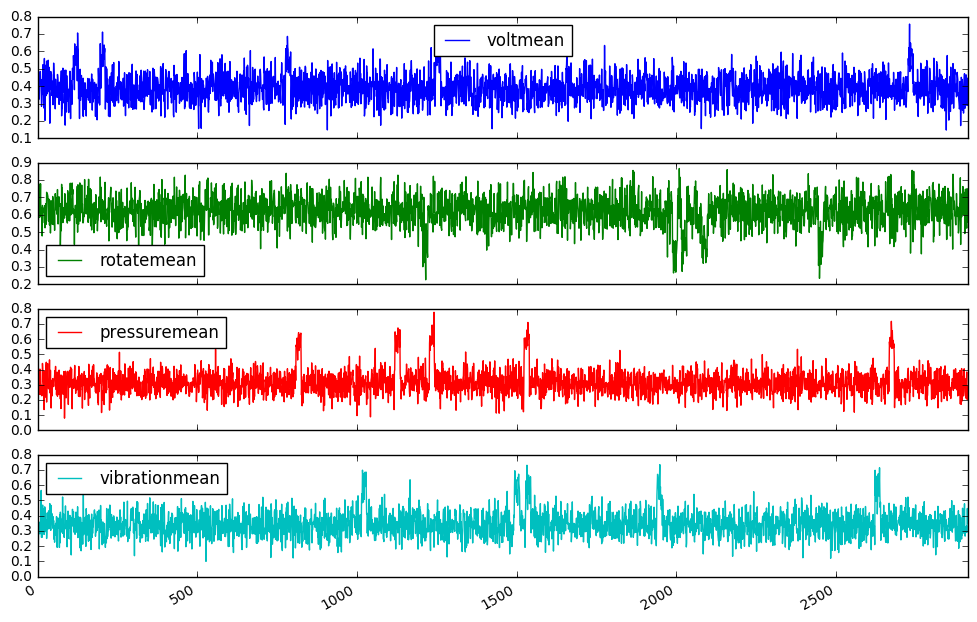

In [128]:
df_X_plot = df_X.loc[df_X['machineID'] == 1]
df_X_plot[feat_col].plot(subplots=True, figsize=(12, 8) )

In [129]:
num_machines = 50
df_X = df_X[df_X['machineID'] <= num_machines]
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145818 entries, 0 to 145817
Data columns (total 6 columns):
datetime         145818 non-null datetime64[ns]
machineID        145818 non-null int64
voltmean         145818 non-null float64
rotatemean       145818 non-null float64
pressuremean     145818 non-null float64
vibrationmean    145818 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 7.8 MB


Here, we pick a sequence length which is the window for LSTMs to look back. This may be viewed similar to picking window sizes for calculating rolling features manually such as the average, minimum, maximum values or outliers in the window. As pointed out earlier, the idea of using LSTMs is to let the model extract abstract features out of the sequence of past values rather than calcualting those manually.

In [130]:
# sequence length which is the window/time steps for LSTM to look back
seq_len = 8 #(measurements are taken every 3 hours ) 

In [131]:
# reshape features into (samples, time steps, features) 
def gen_sequence(machine_df, sequence_length):
    data_array = machine_df[['voltmean', 'rotatemean', 'pressuremean', 'vibrationmean']].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-sequence_length), range(sequence_length, num_elements)):
        yield data_array[start:stop, :]

In [132]:
seq_gen = (list(gen_sequence(df_X[df_X['machineID']==id], seq_len)) for id in df_X['machineID'].unique())

In [133]:
seq_array = np.concatenate(list(seq_gen))
seq_array.shape

(145418, 8, 4)

In [134]:
seq_array[0:3]

array([[[ 0.47115472,  0.60255127,  0.24414106,  0.37486433],
        [ 0.43862777,  0.59912662,  0.32635811,  0.23860015],
        [ 0.30073863,  0.55841072,  0.30468758,  0.23832634],
        [ 0.38778711,  0.60887912,  0.33553171,  0.34812819],
        [ 0.32558359,  0.67963121,  0.33936871,  0.35910747],
        [ 0.32571009,  0.61856312,  0.35778448,  0.28770503],
        [ 0.40261811,  0.5851551 ,  0.23980928,  0.32894899],
        [ 0.4286676 ,  0.77733156,  0.40351595,  0.28009401]],

       [[ 0.43862777,  0.59912662,  0.32635811,  0.23860015],
        [ 0.30073863,  0.55841072,  0.30468758,  0.23832634],
        [ 0.38778711,  0.60887912,  0.33553171,  0.34812819],
        [ 0.32558359,  0.67963121,  0.33936871,  0.35910747],
        [ 0.32571009,  0.61856312,  0.35778448,  0.28770503],
        [ 0.40261811,  0.5851551 ,  0.23980928,  0.32894899],
        [ 0.4286676 ,  0.77733156,  0.40351595,  0.28009401],
        [ 0.48458426,  0.69009464,  0.23590514,  0.30154129]],

    

In [135]:
train_size = int(seq_array.shape[0]* 0.7)
train_X = seq_array[:train_size]
test_X = seq_array[train_size:]
print(train_X.shape)
print(test_X.shape)

(101792, 8, 4)
(43626, 8, 4)


In [137]:
# generate labels
def gen_labels(machine_df, sequence_length):
    data_array = machine_df[['comp1','comp2','comp3','comp4','none']].values
    num_elements = data_array.shape[0]
    #yield data_array[sequence_length:num_elements, :]
    return data_array[sequence_length:num_elements, :]

In [138]:
df_Y = df[['machineID']].join(df_Y)
df_Y = df_Y[df_Y['machineID'] <= num_machines]
df_Y.head()

,machineID,comp1,comp2,comp3,comp4,none
0,1,0,0,0,0,1
1,1,0,0,0,0,1
2,1,0,0,0,0,1
3,1,0,0,0,0,1
4,1,0,0,0,0,1


In [139]:
df_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145818 entries, 0 to 145817
Data columns (total 6 columns):
machineID    145818 non-null int64
comp1        145818 non-null uint8
comp2        145818 non-null uint8
comp3        145818 non-null uint8
comp4        145818 non-null uint8
none         145818 non-null uint8
dtypes: int64(1), uint8(5)
memory usage: 2.9 MB


In [140]:
label_gen = [gen_labels(df_Y[df_Y['machineID']==id], seq_len) for id in df_Y['machineID'].unique()]
#label_gen = (list(gen_labels(df_Y[df_Y['machineID']==id], seq_len)) for id in df_Y['machineID'].unique())

In [141]:
label_array = np.concatenate(label_gen)
label_array.shape

(145418, 5)

In [142]:
train_Y = label_array[:train_size]
test_Y = label_array[train_size:]
print(train_Y.shape)
print(test_Y.shape)

(101792, 5)
(43626, 5)


In [143]:
# build the LSTM model
nb_features = 4
nb_out = train_Y.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(seq_len, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [144]:
model.fit(train_X, train_Y, epochs=5, batch_size = 200, validation_split=0.05, verbose=2)

Train on 96702 samples, validate on 5090 samples
Epoch 1/5
16s - loss: 0.1563 - acc: 0.9797 - val_loss: 0.1228 - val_acc: 0.9811
Epoch 2/5
13s - loss: 0.1292 - acc: 0.9797 - val_loss: 0.1214 - val_acc: 0.9811
Epoch 3/5
13s - loss: 0.1291 - acc: 0.9797 - val_loss: 0.1214 - val_acc: 0.9811
Epoch 4/5
13s - loss: 0.1288 - acc: 0.9797 - val_loss: 0.1222 - val_acc: 0.9811
Epoch 5/5
13s - loss: 0.1287 - acc: 0.9797 - val_loss: 0.1220 - val_acc: 0.9811


In [145]:
print(model.metrics_names)
model.evaluate(test_X, test_Y, verbose=2)

['loss', 'acc']


[0.12248220648132382, 0.98056205015357811]

In [146]:
y_pred = model.predict_classes(test_X)
y_pred
np.unique(y_pred)

43626/43626 [==============================] - 12s      

array([4], dtype=int64)

In [147]:
y_true = pd.DataFrame(test_Y).idxmax(1).values
y_true
np.unique(y_true)

array([0, 1, 2, 3, 4], dtype=int64)

In [148]:
print('Confusion matrix\n- x-axis is true labels (comp1, comp2, comp3, comp4, none.)\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

Confusion matrix
- x-axis is true labels (comp1, comp2, comp3, comp4, none.)
- y-axis is predicted labels


array([[    0,     0,     0,     0,   224],
       [    0,     0,     0,     0,   312],
       [    0,     0,     0,     0,   144],
       [    0,     0,     0,     0,   168],
       [    0,     0,     0,     0, 42778]])

In [149]:
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  [ 0.          0.          0.          0.          0.98056205] 
 recall =  [ 0.  0.  0.  0.  1.]


C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Above results show that the model was not able to catch any failures and classifed all the test data as non-failures. There maybe various reasons of this model performing poorly such as usage of a limited dataset. As laid out in the future extensions,  it maybe possible to get more sensible results by using the full set of data and time based train-test split.